In [7]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
#from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import numpy
import datetime
from datetime import timedelta

%matplotlib inline

In [3]:
#Coding up the Model Definition

# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (T_inc**-1) * E

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (T_inc**-1) * E - (T_inf**-1) * I

# Recovered/Remove/deceased equation
def dR_dt(I, T_inf):
    return (T_inf**-1) * I


def SEIR_model(t, y, R_t, T_inf_t, T_inc,R_0,L,k,t_inf_0,t_inf_1):
    
    if callable(R_t):
        reproduction = R_t(t,R_0,L,k)
    else:
        reproduction = R_t
    
    if callable(T_inf_t):
        Inf_duartion = T_inf_t(t,t_inf_0,t_inf_1)
    else:
        Inf_duartion = T_inf_t
        
    S, E, I, R = y
    
    S_out = dS_dt(S, I, reproduction, Inf_duartion)
    E_out = dE_dt(S, E, I, reproduction, Inf_duartion, T_inc)
    I_out = dI_dt(I, E, T_inc, Inf_duartion)
    R_out = dR_dt(I, Inf_duartion)
    
    return [S_out, E_out, I_out, R_out]

In [759]:
#Loading the  i/p data
df_All_Cases  = pd.read_csv(r"C:\Covid19_SEIR\covid_19_clean_complete.csv")
df_Population  = pd.read_csv(r"C:\Covid19_SEIR\Country_Population.csv") 

In [591]:
# Time varying transmission rate

import math 
def time_varying_R(t,R_01,L_1,k_1): 
    return R_01 / (1 + (t/L_1)**k_1)


def time_varying_T(t,t_inf_0,t_inf_1):
    exponent = -t/(t_inf_1)
    if t<70:
        return t_inf_0 
    else:
        return t_inf_0*math.exp(exponent)

def time_varying_T2(t,t_inf_0,t_inf_1):
    exponent = -t/(t_inf_1)
    return t_inf_0*math.exp(exponent)  

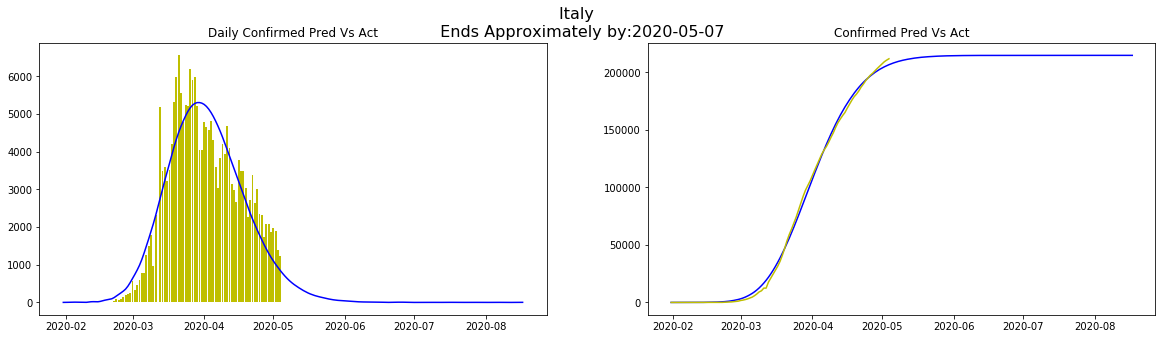

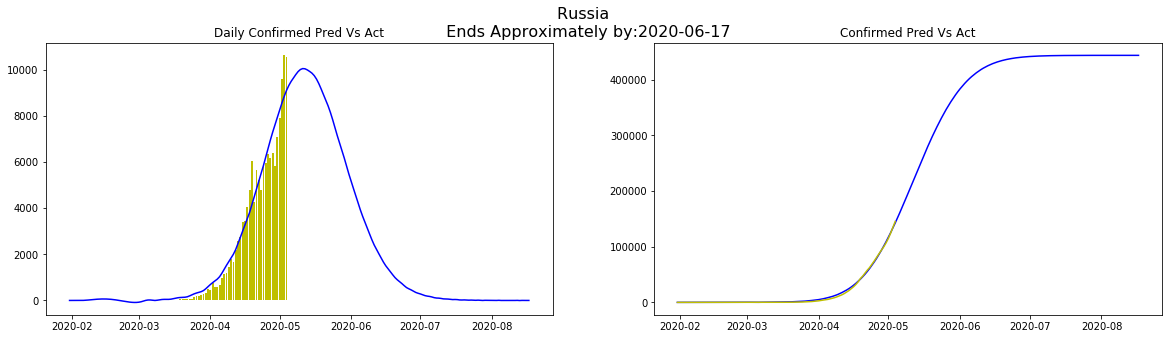

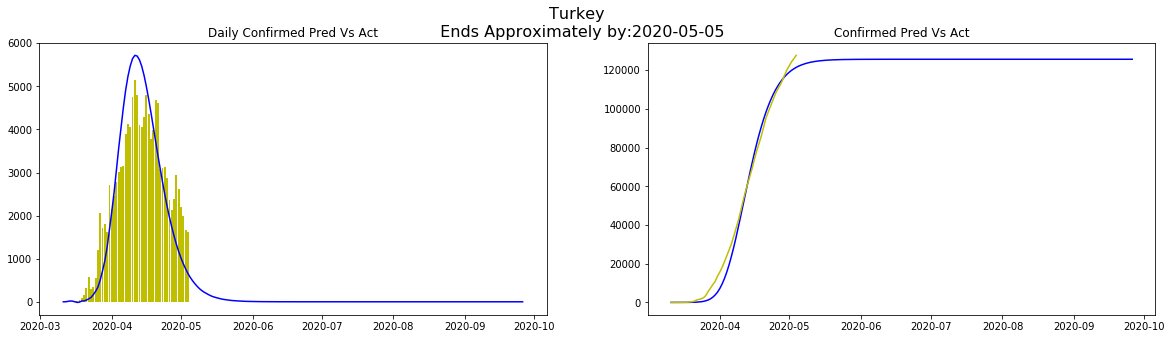

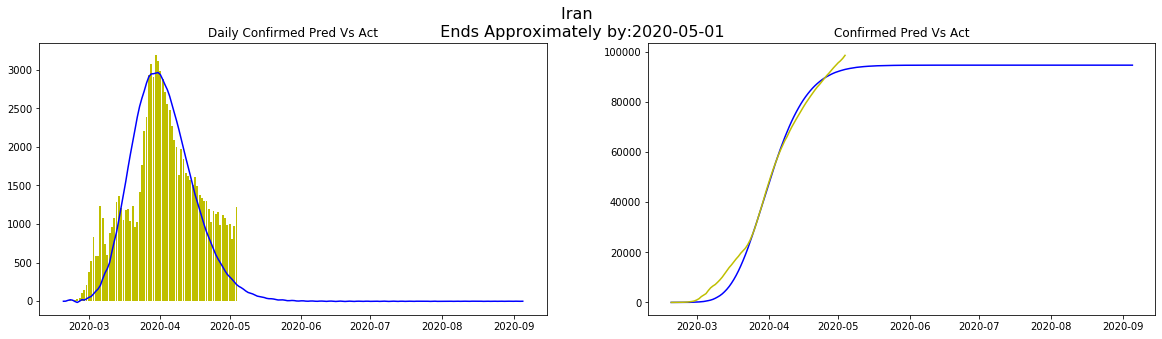

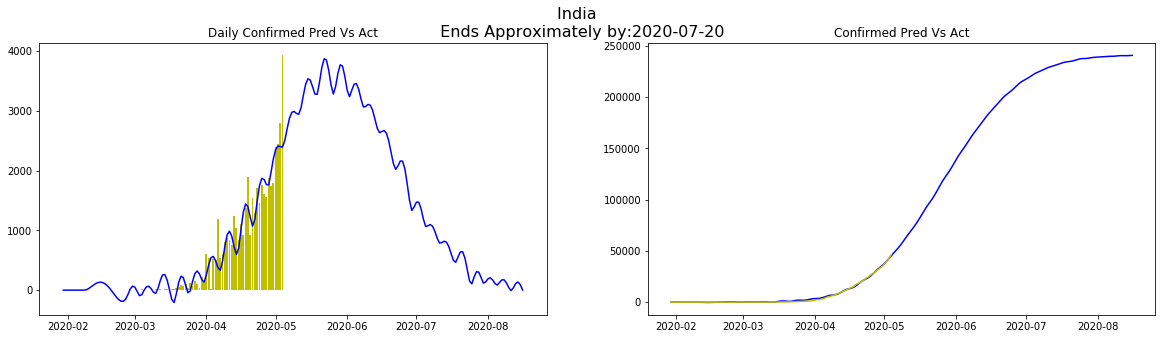

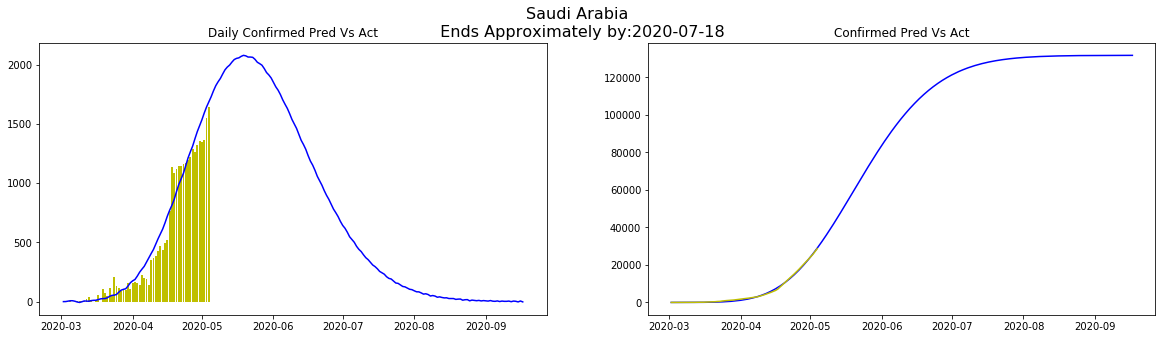

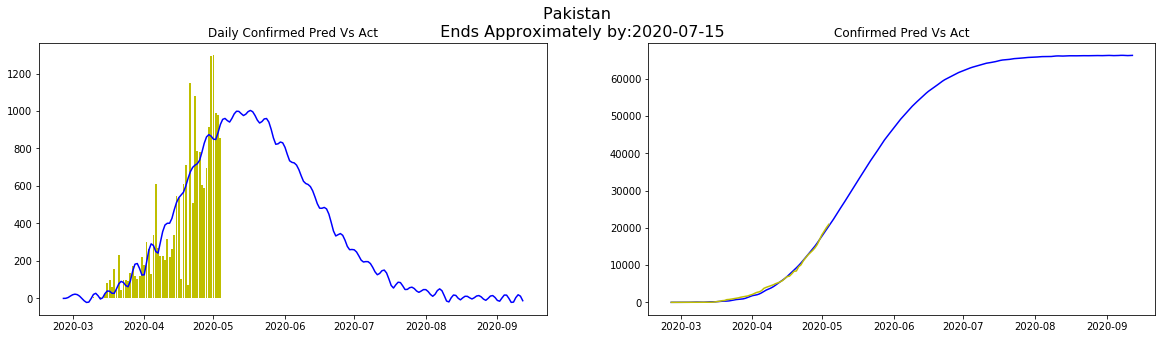

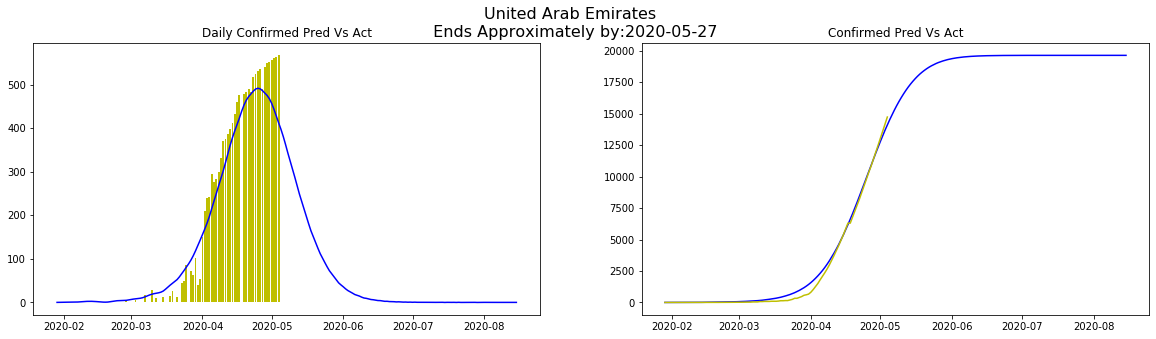

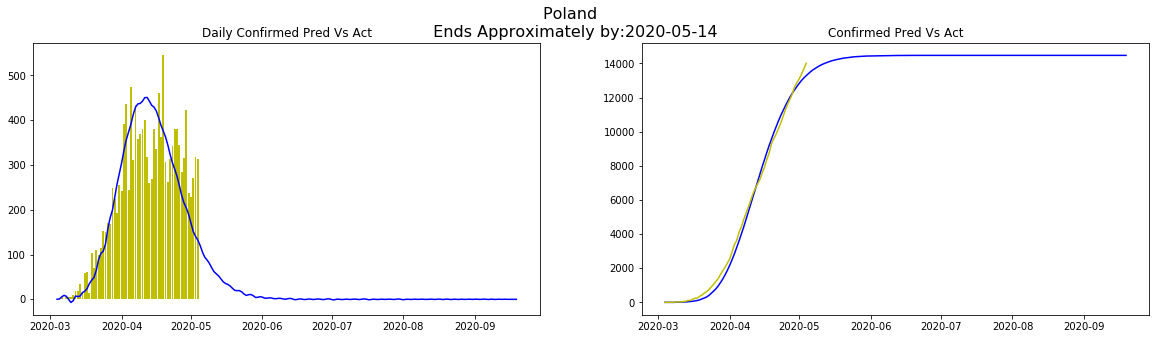

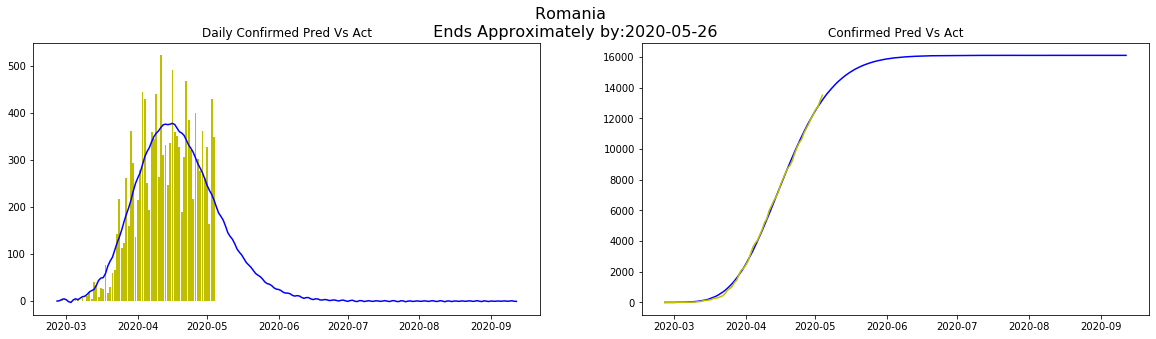

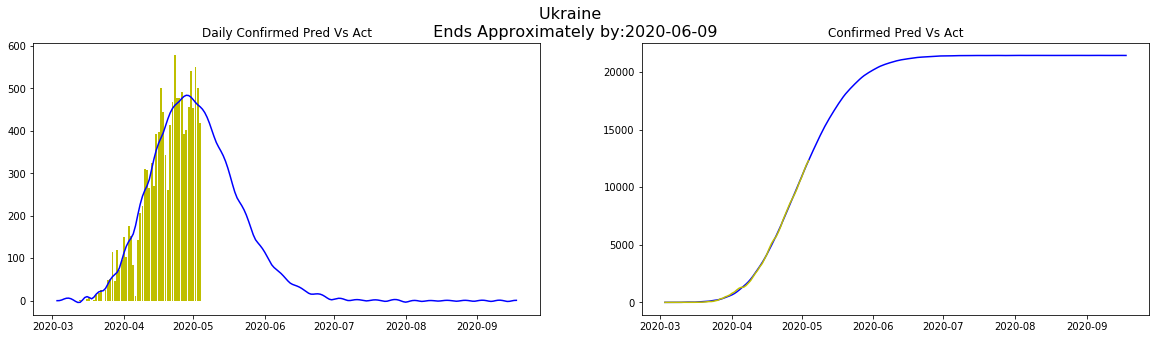

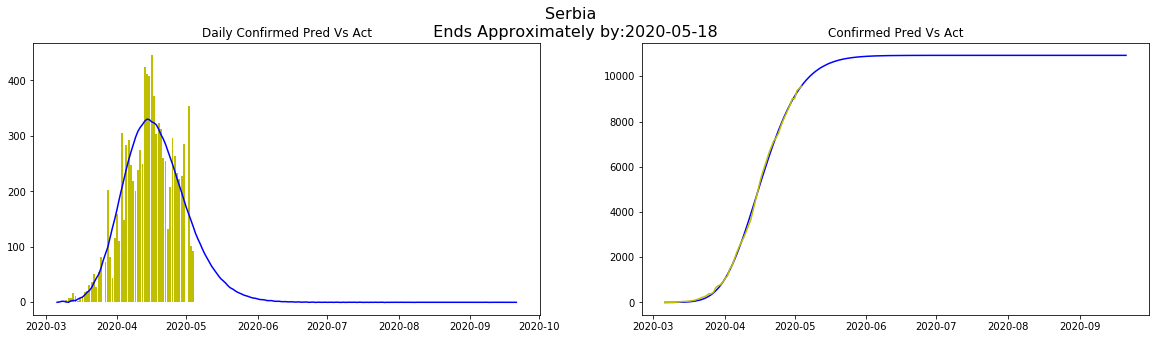

In [813]:
country_list = ['Italy','Russia','Turkey','Iran','India','Saudi Arabia','Pakistan','United Arab Emirates',
'Poland','Romania','Ukraine','Serbia','Bangladesh','Czech','Egypt','Finland','Kuwait','Kazakhstan',
'Bahrain','Hungary','Thailand','Afghanistan','Oman','Armenia','Iraq','Uzbekistan','Croatia',
'Azerbaijan','Bosnia and Herzegovina','Bulgaria','North Macedonia','Slovenia','Slovakia','Djibouti',
'Kyrgyzstan','Lebanon','Sri Lanka','Sudan','Tanzania','Kenya','Jordan','Montenegro',
'Uganda','Nepal','South Sudan','Syria','Yemen']

for country in country_list[:12]:
    df_Cases=df_All_Cases[df_All_Cases["Country/Region"]==country][["Country/Region","Date","Confirmed","Deaths","Recovered"]].groupby(["Country/Region","Date"]).sum().reset_index()
    df_Cases["Date"]=pd.to_datetime(df_Cases["Date"])
    df_Cases=df_Cases.sort_values("Date")
    df_Cases=df_Cases[df_Cases.Confirmed>0].reset_index(drop=True)
    df_final = df_Cases.merge(df_Population,left_on= "Country/Region",right_on ="Country")


#deriving the input data column for training

    xdata = np.arange(len(df_final.Date))
    xdata
#ydata = np.array(input_data.Active)
#ydata = np.array(input_data.Confirmed)
    ydata = np.array(df_final.Confirmed.diff().fillna(0))
    ydata2 = np.array(df_final.Confirmed)
    ydata



# wrapper to solve the model with population number function parameters

    T_inc = 5.5  # average incubation period
#T_inf = 3 # average infectious period
    n_infected =df_final.Confirmed[0]
    N= min(df_final.Population)
    s = (N - n_infected)/ N
    e = 0
    i = n_infected / N
    r = 0.
#SEIR_model(t, y, R_t, T_inf, T_inc,R_0,L,k)
    def solve_inf (t,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit):
        return solve_ivp(SEIR_model, [0, len(df_final.Date)], [s, e, i, r], 
                 args=(time_varying_R, time_varying_T2,T_inc,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit),
                 t_eval=t).y[1][:len(df_final.Date)]*N/T_inc 

    def solve_conf(t,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit):
        return solve_ivp(SEIR_model, [0, len(df_final.Date)], [s, e, i, r], 
                 args=(time_varying_R,time_varying_T2,T_inc,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit),
                 t_eval=t).y[2][:len(df_final.Date)]*N + solve_ivp(SEIR_model, [0, len(df_final.Date)], [s, e, i, r], 
                 args=(time_varying_R,time_varying_T2, T_inc,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit),
                 t_eval=t).y[3][:len(df_final.Date)]*N

    def combinedFunction(t,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit):
        return np.append(solve_inf (t,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit),solve_conf(t,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit))


    popt, pcov = curve_fit(combinedFunction, xdata ,np.append(ydata,ydata2),bounds=([1,20,1,2,50], [7, 80, 5,12,250]))
#popt, pcov = curve_fit(solve_conf, xdata,ydata2,bounds=([1,20,1,2,50], [7, 80, 5,12,250]))
    #print ('Optial Parm Values')
    #print(popt)
    #print("Population")
    #print(N)


    max_days = 250 
##SEIR_model(t, y, R_t, T_inf_t, T_inc,R_0,L,k,t_inf_0,t_inf_1)
    sol2 = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], 
                 args=(time_varying_R, time_varying_T2,T_inc,*popt),
                 t_eval=np.arange(max_days))
#plot_model_and_predict( N, sol2, N,title = 'SEIR Model (with intervention)')

#sol3 = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], 
                 #args=(time_varying_R, time_varying_T2,T_inc,*popt2),
                 #t_eval=np.arange(max_days))

#plot_model_and_predict( N, sol3, N,title = 'SEIR Model (with intervention)')

    Model_Forecast = pd.DataFrame({"Pred_Confirmed":sol2.y[2][:200]*N+sol2.y[3][:200]*N,"Pred_Daily_Cases":sol2.y[1][:200]*N/T_inc})

    Final_Full_Df=Model_Forecast.join (df_final, how ='left')
    Final_Full_Df['Day'] = Final_Full_Df.index
    Final_Full_Df['First_Date'] = min(Final_Full_Df.Date)
    Final_Full_Df['New_date']=pd.to_datetime(Final_Full_Df.First_Date) + pd.to_timedelta(Final_Full_Df.Day, unit="D")
    Final_Full_Df['Daily_Confirmed'] =Final_Full_Df.Confirmed.diff().fillna(0)

   # print("First Date")
    #print(min(Final_Full_Df.Date))

    x=np.array(Final_Full_Df.New_date)

    y1 =np.array(Final_Full_Df.Pred_Daily_Cases)
    y2 =np.array(Final_Full_Df.Daily_Confirmed)
    y3 = np.array(Final_Full_Df.Pred_Confirmed)
    y4 = np.array(Final_Full_Df.Confirmed)


    fig, ax = plt.subplots(1, 2, figsize=(20,5))
    ax[0].plot(x,y1,label='Pred Daily Cases', color='b')
    ax[0].bar(x,y2,label='Act Daily Cases', color='y')
    ax[0].set_title('Daily Confirmed Pred Vs Act')

    ax[1].plot(x,y3,label='Pred Confirmed', color='b')
    ax[1].plot(x,y4,label='Act Confirmed', color='y')
    ax[1].set_title('Confirmed Pred Vs Act')
    approx_end_date=max(Final_Full_Df[Final_Full_Df.Pred_Confirmed<0.975*max(Final_Full_Df.Pred_Confirmed)].New_date)
    plt.suptitle("{} \n Ends Approximately by:{}".format(country,approx_end_date.strftime('%Y-%m-%d')), fontsize=16)

In [576]:
# wrapper to solve the model with population number function parameters

T_inc = 5.5  # average incubation period
#T_inf = 3 # average infectious period
n_infected =input_data.Confirmed[0]
N= min(input_data.Population)
s = (N - n_infected)/ N
e = 0
i = n_infected / N
r = 0.
#SEIR_model(t, y, R_t, T_inf, T_inc,R_0,L,k)
def solve_inf (t,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit):
    return solve_ivp(SEIR_model, [0, len(input_data.Date)], [s, e, i, r], 
                 args=(time_varying_R, time_varying_T2,T_inc,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit),
                 t_eval=t).y[1][:len(input_data.Date)]*N/T_inc 

def solve_conf(t,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit):
    return solve_ivp(SEIR_model, [0, len(input_data.Date)], [s, e, i, r], 
                 args=(time_varying_R,time_varying_T2,T_inc,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit),
                 t_eval=t).y[2][:len(input_data.Date)]*N + solve_ivp(SEIR_model, [0, len(input_data.Date)], [s, e, i, r], 
                 args=(time_varying_R,time_varying_T2, T_inc,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit),
                 t_eval=t).y[3][:len(input_data.Date)]*N

def combinedFunction(t,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit):
    return np.append(solve_inf (t,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit),solve_conf(t,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit))

popt3, pcov3 = curve_fit(combinedFunction, xdata ,np.append(ydata,ydata2),bounds=([1,20,1,2,50], [7, 80, 5,12,250]))
print ('Optial Parm Values')
popt3


In [519]:
popt2, pcov2 = curve_fit(solve_conf, xdata, ydata2,bounds=([1,20,1,2,70], [7, 80, 5,8,250]))
print ('Optial Parm Values')
popt2

Optial Parm Values


array([ 3.1111443 , 56.08899905,  4.99999999,  3.2021368 , 78.07704749])

In [577]:
popt3, pcov3 = curve_fit(combinedFunction, xdata ,np.append(ydata,ydata2),bounds=([1,20,1,2,50], [7, 80, 5,12,250]))
print ('Optial Parm Values')
popt3

Optial Parm Values


array([  4.83513213,  25.02317714,   1.        ,   4.59499325,
       209.41636046])

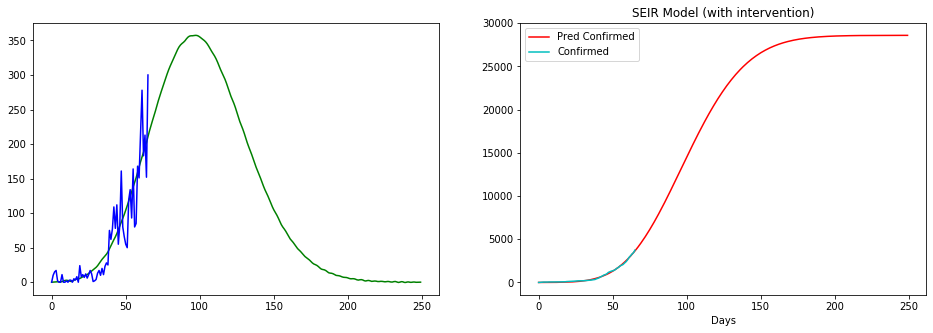

In [578]:
# solving the model for the optimal Parameters and plotting the actual vs pred curve

T_inc = 5.5  # average incubation period
#T_inf = 3 # average infectious period
# R_0, L, k =[5.35,35.3, 1.997 ] Italy Best Fit
# R_0, L, k =[4.55,46.9, 3 ] Spain Best Fit
# R_0, L, k =[5.32,30, 2.53 ] SK Best Fit
#R_0, L, k =[3.32,48.86, 3  ] Kuwait Best Fit
#R_0, L, k =[3.12,49.06, 3  ] Afghanistan
#R_0, L, k =[4.33803162, 32.73653565,  1.   ] Bahrain
#R_0, L, k =[ 6.75670379, 20.        ,  1.17222081 ] SA
#R_0, L, k  =[ 6.18986302, 20.        ,  1.49011801] PK
#R_0, L, k  =[ 3.5, 64.        ,  2      ] RU
#R_0, L, k  =[ 3, 60        ,  2     ] OM
#R_0, L, k  =[ 8, 25.9       ,  3       ] TR
#R_0, L, k  =[ 4.42916852, 22.89427823,  1.]GE

R_0, L, k,T_inf_0,T_inf_1 =[4.83513213,  25.02317714,   1.        ,   4.59499325,
       209.41636046]  

max_days = 250 


N= min(input_data.Population)
n_infected =input_data.Confirmed[0]
# Initial conditions for SEIR model
s = (N - n_infected)/ N
e = 0
i = n_infected / N
r = 0.
##SEIR_model(t, y, R_t, T_inf_t, T_inc,R_0,L,k,t_inf_0,t_inf_1)
sol2 = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], 
                 args=(time_varying_R, time_varying_T2,T_inc,R_0,L,k,T_inf_0,T_inf_1),
                 t_eval=np.arange(max_days))
plot_model_and_predict( N, sol2, title = 'SEIR Model (with intervention)',N)

In [492]:
spread = pd.DataFrame({"Confirmed":sol2.y[2][:200]*N+sol2.y[3][:200]*N,"Daily Cases":sol2.y[1][:200]*N/5.5})
output_csv = spread.to_csv (r'C:\Covid19_SEIR\SK_Output3.csv', header=True)

Text(0.5, 1.0, 'Total Confirmed vs Daily Confirmed - Actual')

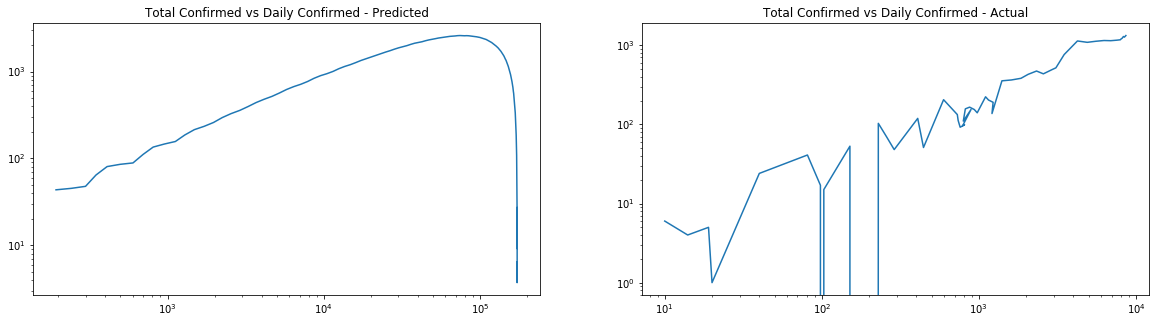

In [573]:
x= sol2.y[2][20:200]*N+sol2.y[3][20:200]*N
y = sol2.y[1][20:200]*N/5.5
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].plot(x,y)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Total Confirmed vs Daily Confirmed - Predicted')
ax[1].plot(input_data.Confirmed.diff().fillna(0).rolling(7).sum(),ydata)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Total Confirmed vs Daily Confirmed - Actual')

In [796]:
# function to plot the final actual vs pred

def plot_model_and_predict( pop, solution,title='Australia'):
    sus, exp, inf, rec = solution.y*pop
    
    f = plt.figure(figsize=(16,8))
    ax = f.add_subplot(2,2,1)
    #ax.plot(inf, 'r', label='Infected');
    #ax.plot(rec, 'y', label='Removed');
    ax.plot(exp/5.5, 'g', label='Pred Daily Cases');
    ax.plot(ydata, 'b', label='Daily Cases');
    ax2 = f.add_subplot(2,2,2)
    ax2.plot(ydata2, 'c', label='Confirmed');
    ax2.plot(inf+rec, 'r', label='Pred Confirmed');
    plt.title(title)
    plt.xlabel("Days", fontsize=10);
    plt.legend(loc='best');